# Module 2 Final Project Submission

* Student name: **Chelsea Power**
* Student pace: **part time**
* Scheduled project review date/time: **May 17, 2019 at 6:30 pm ET**
* Instructor name: **Joe San Pietro**
* Blog post URL: **TBD**

## Question 1: Part I - Do discounts increase customer purchases?

    Ho: Discounts do not have an effect on the number of products ordered.

    Ha: Discounts have an effect on the number of products ordered.

In [1]:
# Import required libraries
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as _stats
from scipy import stats

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Connect an engine and connect to the Northwind database
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)

# Create session to execute SQL commands
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

# Extract Order Detail data as a pandas dataframe using a SQL query
df = pd.read_sql_query('''
 SELECT * 
 FROM OrderDetail
 ''', engine)

2019-05-20 14:46:21,227 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-20 14:46:21,228 INFO sqlalchemy.engine.base.Engine ()
2019-05-20 14:46:21,228 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-20 14:46:21,229 INFO sqlalchemy.engine.base.Engine ()
2019-05-20 14:46:21,230 INFO sqlalchemy.engine.base.Engine 
 SELECT * 
 FROM OrderDetail
 
2019-05-20 14:46:21,231 INFO sqlalchemy.engine.base.Engine ()


In [2]:
# Display OrderDetail as a panda dataframe
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


### Split the data into two separate groups to test the difference.

In [3]:
# Create control group: customers who did not receive a discount
control = df[df['Discount'] == 0]
control = control['Quantity']

# Create experimental group: customers who received a discount
experimental = df[df['Discount'] != 0]
experimental = experimental['Quantity']

In [4]:
# Calculate the difference between distribution means
control.mean()
experimental.mean()
experimental.mean() - control.mean()

5.394523243866239

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


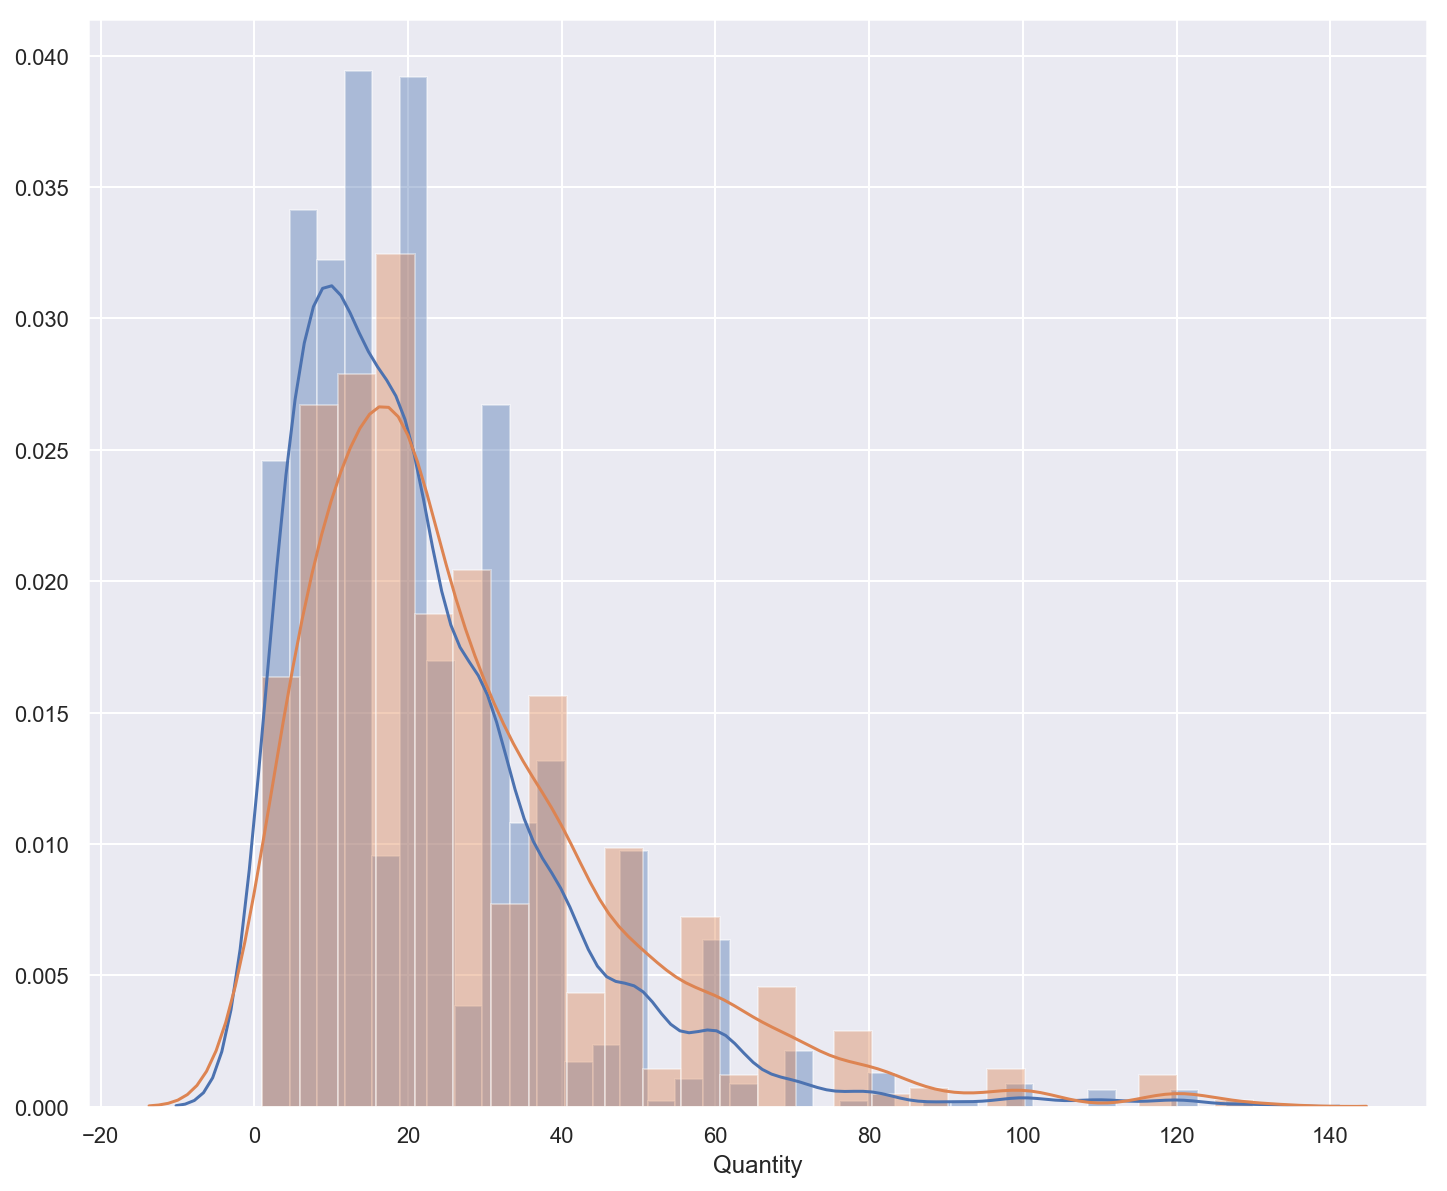

In [5]:
# Plot data and run normality test
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control) # Blue distribution
sns.distplot(experimental) # Orange distribution

### Create a sample distribution of the sample mean to continue the hypothesis testing because the distrubtion is skewed to the right

In [6]:
# Create function to sample with replacement
def get_sample(df, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df)
        sample.append(x)
    return sample

# Create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# Combine functions to create a sample distribution
# Create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    return sample_dist

# Create sample distributions of sample mean for control and target
control_sample = create_sample_distribution(control)
exp_sample = create_sample_distribution(experimental)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


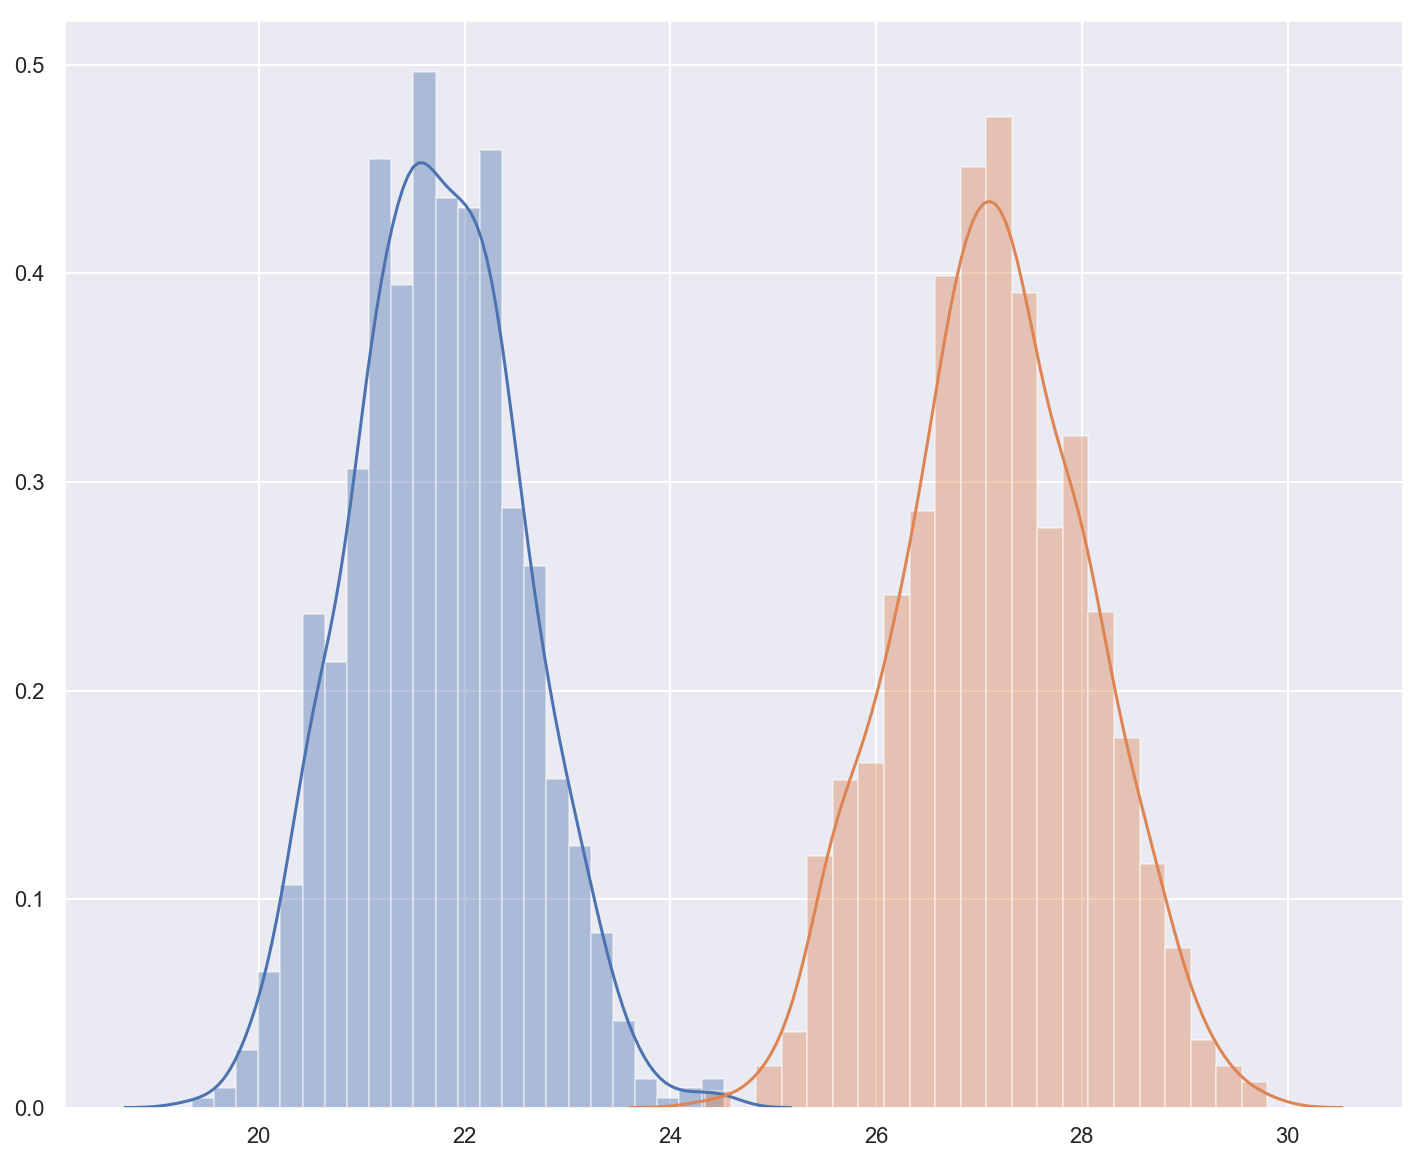

In [7]:
# Plot sample Distribution
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control_sample) # Blue distribution
sns.distplot(exp_sample) # Orange distribution

In [8]:
# Test whether variances are equal
np.var(control) == np.var(experimental)

False

### Perform ANOVA test

Formula:

```Control_Column ~ C(factor_col1) + factor_col2 + C(factor_col3) + ... + X```

In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

discount = df.Discount
quantity = df.Quantity

formula = 'quantity ~ C(discount)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F        PR(>F)
C(discount)   21258.403604    10.0  6.011811  4.704231e-09
Residual     758141.232591  2144.0       NaN           NaN


The result **p (4.7e-09) < α**, so we reject the null hypothesis. 

## Question 1: Part II - What discount levels have an effect on the quantity of products ordered? (Does a 5% discount have the same effect as a 20% discount?)

Perform multiple comparison analysis to look at all possible pair means to determine if **discount amounts of 5, 15, 20 and 25%** produce a statistically significant effect on the mean quantity of product ordered.

In [10]:
#Tukey's range test - compares all possible pairs and we can use it to precisely 
#identify difference between two means that's greater than the expected standard error.
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df['Quantity'], df['Discount'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 0.0    0.01  -19.7153 -80.3306 40.9001 False 
 0.0    0.02  -19.7153 -62.593  23.1625 False 
 0.0    0.03  -20.0486 -55.0714 14.9742 False 
 0.0    0.04  -20.7153 -81.3306 39.9001 False 
 0.0    0.05   6.2955   1.5381   11.053  True 
 0.0    0.06  -19.7153 -80.3306 40.9001 False 
 0.0    0.1    3.5217  -1.3783   8.4217 False 
 0.0    0.15   6.6669   1.551   11.7828  True 
 0.0    0.2    5.3096   0.2508  10.3684  True 
 0.0    0.25   6.525    1.3647  11.6852  True 
 0.01   0.02    0.0    -74.2101 74.2101 False 
 0.01   0.03  -0.3333  -70.2993 69.6326 False 
 0.01   0.04    -1.0   -86.6905 84.6905 False 
 0.01   0.05  26.0108  -34.745  86.7667 False 
 0.01   0.06    0.0    -85.6905 85.6905 False 
 0.01   0.1    23.237  -37.5302 84.0042 False 
 0.01   0.15  26.3822  -34.4028 87.1671 False 
 0.01   0.2   25.0248  -35.7554  85.805 False 
 0.01   0

Results of **’reject = True’** means that a significant difference has been observed.

## Question 2: Does the revenue per order vary by different regions?

    Ho: Revenue per order does not vary by region.
    
    Ha: Revenue per order varies by different regions.

In [11]:
# Extract data required as a pandas dataframe using a SQL query
df2 = pd.read_sql_query('''
 SELECT Region, Quantity, OrderID, UnitPrice, Discount
 FROM Customer
 LEFT JOIN "Order" ON Customer.Id
 LEFT JOIN OrderDetail ON OrderID
 ''', engine)

2019-05-20 14:46:29,223 INFO sqlalchemy.engine.base.Engine 
 SELECT Region, Quantity, OrderID, UnitPrice, Discount
 FROM Customer
 LEFT JOIN "Order" ON Customer.Id
 LEFT JOIN OrderDetail ON OrderID
 
2019-05-20 14:46:29,223 INFO sqlalchemy.engine.base.Engine ()


In [12]:
# Display dataframe
df2.head()

,Region,Quantity,OrderId,UnitPrice,Discount
0,Western Europe,12,10248,14.0,0.0
1,Western Europe,10,10248,9.8,0.0
2,Western Europe,5,10248,34.8,0.0
3,Western Europe,9,10249,18.6,0.0
4,Western Europe,40,10249,42.4,0.0


In [13]:
# Calculate the revenue per order
df2['Price_Per_Order'] = df2.Quantity * df2.UnitPrice * (1 - df2.Discount)

# Display dataframe
df2.head()

,Region,Quantity,OrderId,UnitPrice,Discount,Price_Per_Order
0,Western Europe,12,10248,14.0,0.0,168.0
1,Western Europe,10,10248,9.8,0.0,98.0
2,Western Europe,5,10248,34.8,0.0,174.0
3,Western Europe,9,10249,18.6,0.0,167.4
4,Western Europe,40,10249,42.4,0.0,1696.0


In [14]:
#Group Price Per Order by Region
df2['Price_Per_Order'].groupby([df2['Region'],df2['OrderId']]).describe()

count         mean           std      min      25%  \
Region         OrderId                                                       
British Isles  10248     24.0   146.666667  3.524161e+01   98.000   98.000   
               10249     16.0   931.700000  7.893656e+02  167.400  167.400   
               10250     24.0   517.533333  5.403440e+02   77.000   77.000   
               10251     24.0   218.020000  1.002347e+02   95.760   95.760   
               10252     24.0  1199.300000  1.010287e+03   47.500   47.500   
               10253     24.0   481.600000  2.039329e+02  200.000  200.000   
               10254     24.0   185.540000  1.244292e+02   45.900   45.900   
               10255     32.0   622.625000  4.143400e+02  304.000  361.000   
               10256     16.0   258.900000  1.384979e+02  124.800  124.800   
               10257     24.0   373.300000  3.653461e+02   86.400   86.400   
               10258     24.0   538.293333  3.213777e+02  122.880  122.880   
               10259     16.0    50.400000  3.057075e+01   20.800   20.800   
               10260     32.0   376.162500  2.703099e+02   92.400  164.850   
               10261     16.0   224.000000  6.609892e+01  160.000  160.000   
               10262     24.0   194.666667  1.268283e+02   60.800   60.800   
               10263     32.0   468.450000  3.361941e+02  100.800  187.200   
               10264     16.0   347.812500  1.902280e+02  163.625  163.625   
               10265     16.0   588.000000  3.594129e+02  240.000  240.000   
               10266      8.0   346.560000  0.000000e+00  346.560  346.560   
               10267     24.0  1178.866667  1.064638e+03  183.600  183.600   
               10268     16.0   550.600000  4.538104e+02  111.200  111.200   
               10269     16.0   321.100000  2.138920e+02  114.000  114.000   
               10270     16.0   688.000000  2.396086e+02  456.000  456.000   
               10271      8.0    48.000000  0.000000e+00   48.000   48.000   
               10272     24.0   485.333333  1.314481e+02  388.800  388.800   
               10273     40.0   407.456000  2.926102e+02   40.000  142.500   
               10274     16.0   269.300000  7.714983e+01  194.600  194.600   
               10275     16.0   145.920000  1.083196e+02   41.040   41.040   
               10276     16.0   210.000000  1.673129e+02   48.000   48.000   
               10277     16.0   600.400000  1.317847e+02  472.800  472.800   
...                       ...          ...           ...      ...      ...   
Western Europe 11048     28.0   525.000000  0.000000e+00  525.000  525.000   
               11049     56.0   136.800000  1.533756e+01  121.600  121.600   
               11050     28.0   810.000000  0.000000e+00  810.000  810.000   
               11051     28.0    36.000000  0.000000e+00   36.000   36.000   
               11052     56.0   666.000000  4.419639e+02  228.000  228.000   
               11053     84.0  1018.333333  5.205751e+02  640.000  640.000   
               11054     56.0   152.500000  1.286539e+02   25.000   25.000   
               11055    112.0   431.875000  3.819365e+02   67.500  174.375   
               11056     84.0  1246.666667  3.547588e+02  840.000  840.000   
               11057     28.0    45.000000  0.000000e+00   45.000   45.000   
               11058     84.0   286.000000  3.064077e+02   30.000   30.000   
               11059     84.0   612.666667  4.273820e+02  180.000  180.000   
               11060     56.0   133.000000  3.027150e+00  130.000  130.000   
               11061     28.0   510.000000  0.000000e+00  510.000  510.000   
               11062     56.0   203.200000  5.973576e+01  144.000  144.000   
               11063     84.0   447.650000  1.662078e+02  260.550  260.550   
               11064    140.0   866.080000  9.618032e+02   86.400  115.800   
               11065     56.0    94.710000  1.719421e+01   77.670   77.670   
               11066     84.0   309.583333  1.

In [15]:
# Combine Eastern and Southern Europe
df2.loc[(df2.Region == 'Eastern Europe') | (df2.Region == 'Southern Europe'),'Region'] = 'Southern and Eastern Europe'

# Combine Scandinavia and Northern Europe
df2.loc[(df2.Region == 'Scandinavia') | (df2.Region == 'Northern Europe'),'Region'] = 'Northern Europe and Scandinavia'

# Combine Central and South America
df2.loc[(df2.Region == 'Central America') | (df2.Region == 'South America'),'Region'] = 'South and Central America'

# Drop OrderId column now that we have the total revenue
df2.drop(['OrderId'], axis=1, inplace=True)

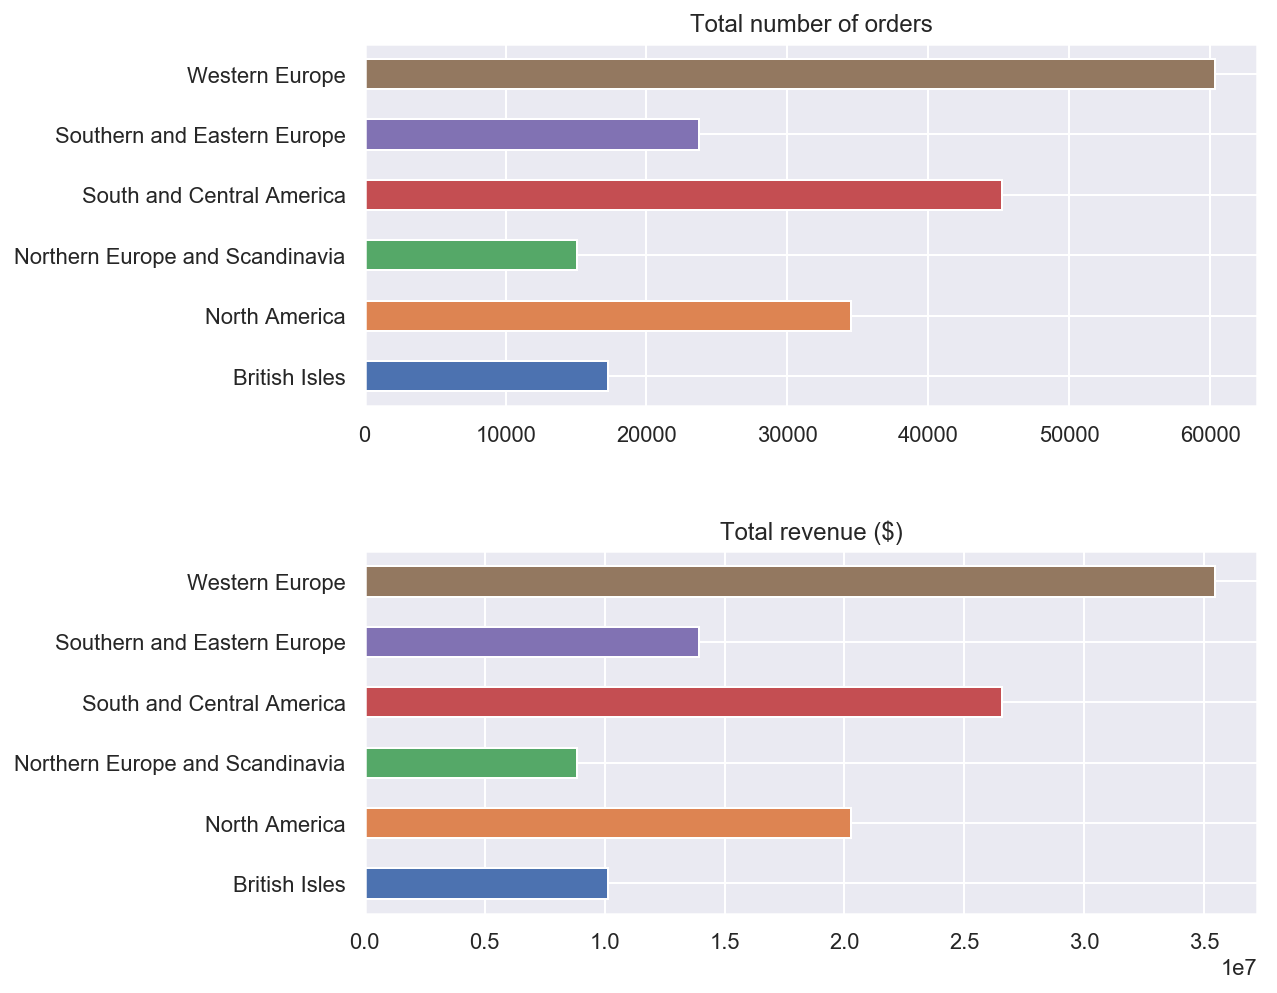

In [16]:
# Plot the number of orders, total revenue per order and average revenue per order for each region
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
df2.groupby(['Region'])['Region'].count().plot(kind='barh', ax=ax1)
df2.groupby(['Region'])['Price_Per_Order'].sum().plot(kind='barh', ax=ax2)
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_title('Total revenue ($)')
ax2.set_ylabel('')
fig.subplots_adjust(hspace=0.4);

In [17]:
# Create control group: Price per order in North America
control = df2[df2['Region'] == 'North America']
control = control['Price_Per_Order']

# Create experimental group: Price per order everywhere else
experimental = df2[df2['Region'] != 'North America']
experimental = experimental['Price_Per_Order']

In [18]:
# Calculate the difference between distribution means
control.mean()
experimental.mean()
experimental.mean() - control.mean()

0.0

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


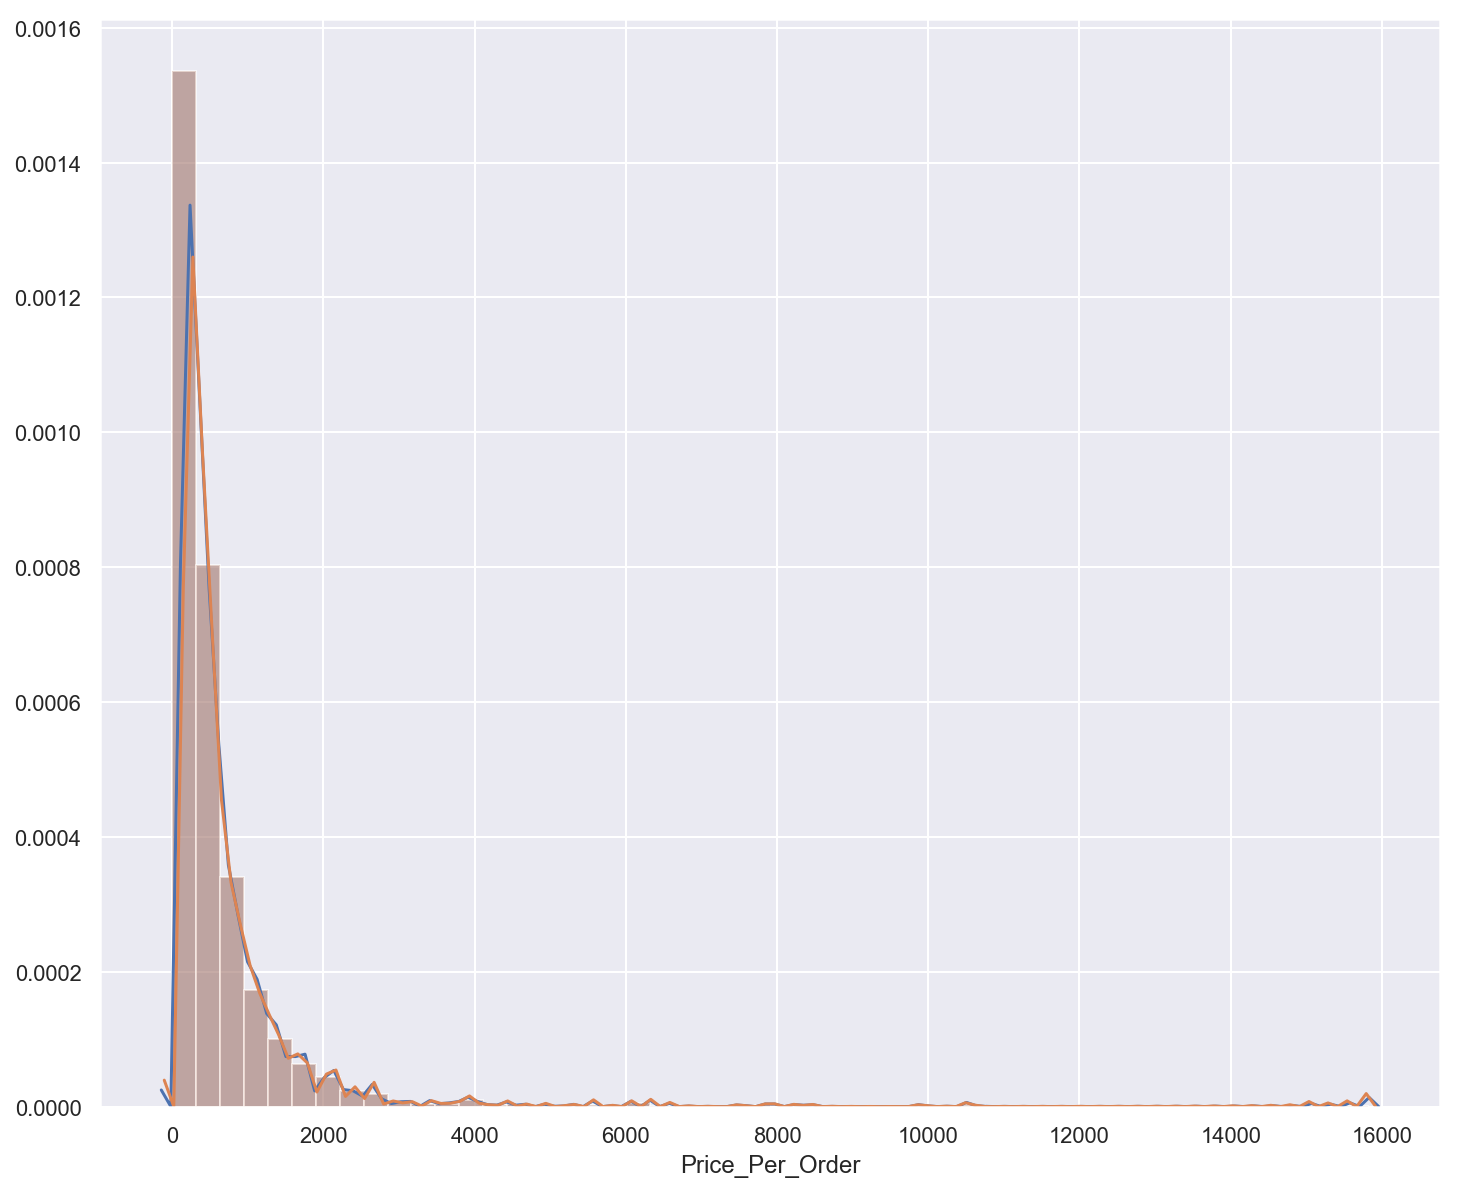

In [19]:
# Plot data and run normality test
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control) # Blue distribution
sns.distplot(experimental) # Orange distribution

In [20]:
# Create function to sample with replacement
def get_sample(df, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df)
        sample.append(x)
    return sample

# Create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# Combine functions to create a sample distribution
# Create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    return sample_dist

# Create sample distributions of sample mean for control and target
control_sample = create_sample_distribution(control)
exp_sample = create_sample_distribution(experimental)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


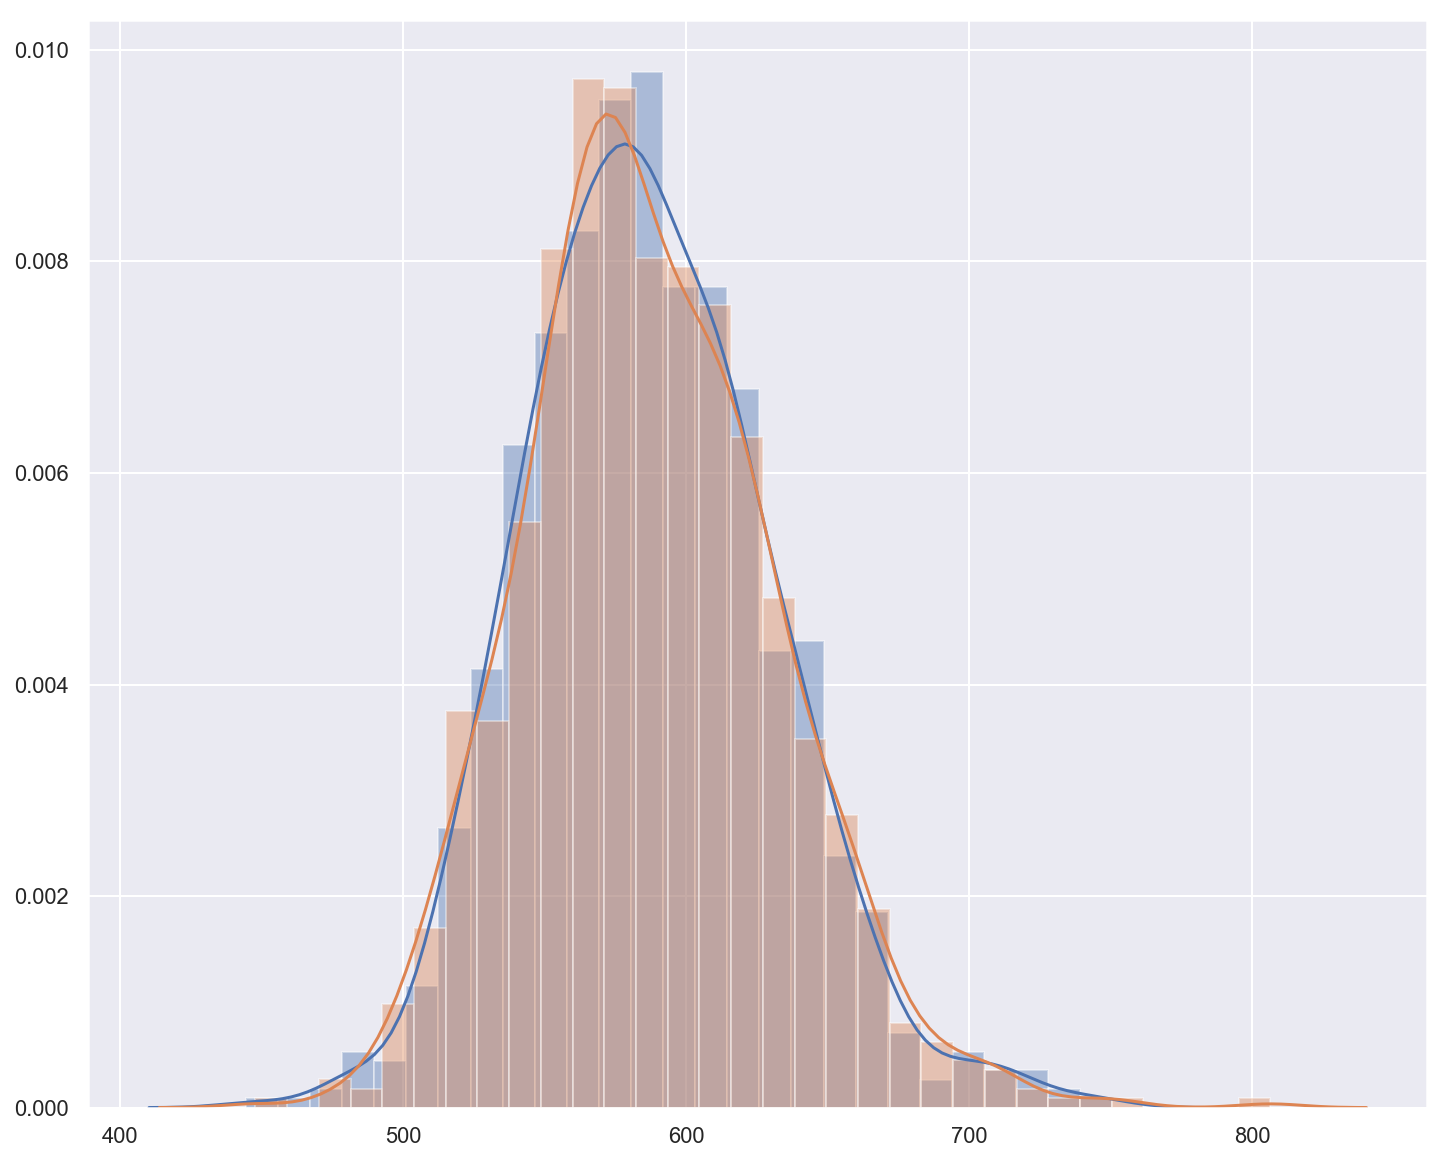

In [21]:
# Plot sample Distribution
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control_sample) # Blue distribution
sns.distplot(exp_sample) # Orange distribution

In [22]:
# Test whether variances are equal
np.var(control) == np.var(experimental)

False

### Perform ANOVA test

In [23]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

Region = df2.Region
Price_Per_Order = df2.Price_Per_Order

formula = 'Price_Per_Order ~ C(Region)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq        df             F  PR(>F)
C(Region)  7.461307e-17       5.0  1.589222e-23     1.0
Residual   1.841347e+11  196099.0           NaN     NaN


The result **p (1.0) < α**, so we reject the null hypothesis.

## Question 3: Does the supply region have an effect on the amount of Chai sold?

    Ho: There is no difference in the quantity of Chai sold between North America and others.

    Ha: There is a regional difference in quantity of Chai sold from North America.

In [24]:
# Extract Order Detail data as a pandas dataframe using a SQL query
df3 = pd.read_sql_query('''
 SELECT Region, ProductName, Quantity, OrderID
 FROM Supplier
 JOIN Product
 ON SupplierID
 LEFT JOIN OrderDetail
 On OrderID
 ''', engine)

2019-05-20 14:46:49,403 INFO sqlalchemy.engine.base.Engine 
 SELECT Region, ProductName, Quantity, OrderID
 FROM Supplier
 JOIN Product
 ON SupplierID
 LEFT JOIN OrderDetail
 On OrderID
 
2019-05-20 14:46:49,404 INFO sqlalchemy.engine.base.Engine ()


In [25]:
# Display Supplier as a panda dataframe
df3.head()

,Region,ProductName,Quantity,OrderId
0,British Isles,Chai,12,10248
1,British Isles,Chai,10,10248
2,British Isles,Chai,5,10248
3,British Isles,Chai,9,10249
4,British Isles,Chai,40,10249


In [26]:
# Drop non-Chai products
df3.drop(df3[ df3['ProductName'] != 'Chai' ].index, inplace=True)

# Combine Northern, Eastern, Southern Europe, Scandinavia and British Isles
df3.loc[(df3.Region == 'Europe') | (df3.Region == 'Southern Europe') | (df3.Region == 'Scandinavia') | (df3.Region == 'British Isles') | (df3.Region == 'Western Europe') | (df3.Region == 'Northern Europe'),'Region'] = 'Europe'

# Combine Eastern Asia, South-East Asia
df3.loc[(df3.Region == 'Eastern Asia') | (df3.Region == 'South-East Asia'),'Region'] = 'Asia'

# Confirm the only products are Chai
df3['ProductName'].unique()

array(['Chai'], dtype=object)

In [27]:
#Group Quantity by Region
df3['Quantity'].groupby(df3['Region']).describe()

,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Asia,6465.0,23.812993,19.019104,1.0,10.0,20.0,30.0,130.0
Europe,36635.0,23.812993,19.017893,1.0,10.0,20.0,30.0,130.0
NSW,2155.0,23.812993,19.022047,1.0,10.0,20.0,30.0,130.0
North America,12930.0,23.812993,19.018368,1.0,10.0,20.0,30.0,130.0
South America,2155.0,23.812993,19.022047,1.0,10.0,20.0,30.0,130.0
Victoria,2155.0,23.812993,19.022047,1.0,10.0,20.0,30.0,130.0


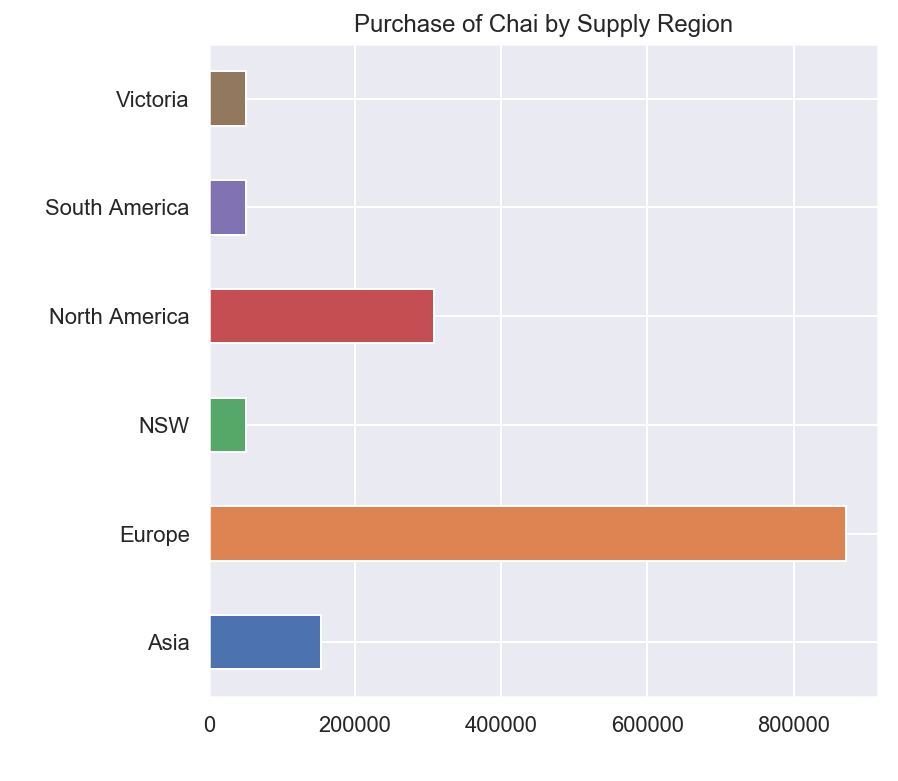

In [28]:
# Plot the Quantity by Supply Region
fig, (ax1) = plt.subplots(1, 1, figsize=(6,6))
df3.groupby(['Region'])['Quantity'].sum().plot(kind='barh', ax=ax1)
ax1.set_title('Purchase of Chai by Supply Region')
ax1.set_ylabel(' ')
ax1.set_xlabel(' ')
fig.subplots_adjust(hspace=0.1);

In [29]:
# Create control group: Purchase of Chai in North America
control = df3[df3['Region'] == 'North America']
control = control['Quantity']

# Create experimental group: Purchase of Chai in North America
experimental = df3[df3['Region'] == 'Europe']
experimental = experimental['Quantity']

In [30]:
# Calculate the difference between distribution means
control.mean()
experimental.mean()
experimental.mean() - control.mean()

0.0

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


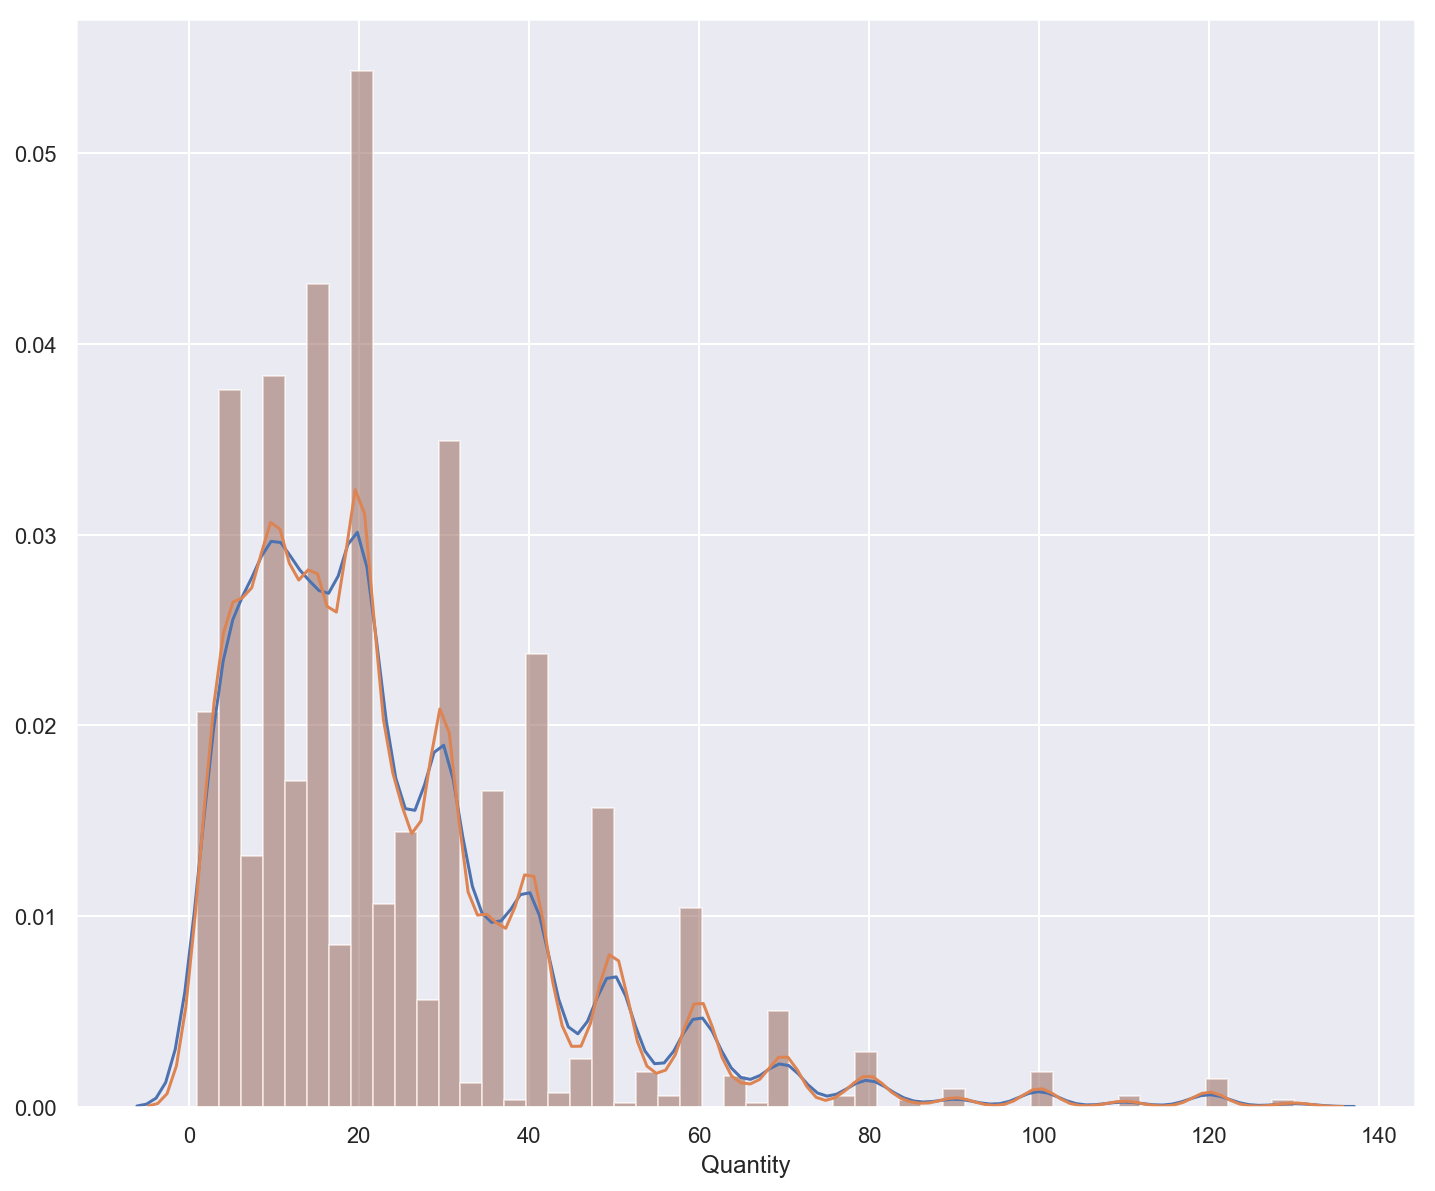

In [31]:
# Plot data and run normality test
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control) # Blue distribution
sns.distplot(experimental) # Orange distribution

In [32]:
# Create function to sample with replacement
def get_sample(df3, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df3)
        sample.append(x)
    return sample

# Create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# Combine functions to create a sample distribution
# Create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df3, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df3, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    return sample_dist

# Create sample distributions of sample mean for control and target
control_sample = create_sample_distribution(control)
exp_sample = create_sample_distribution(experimental)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


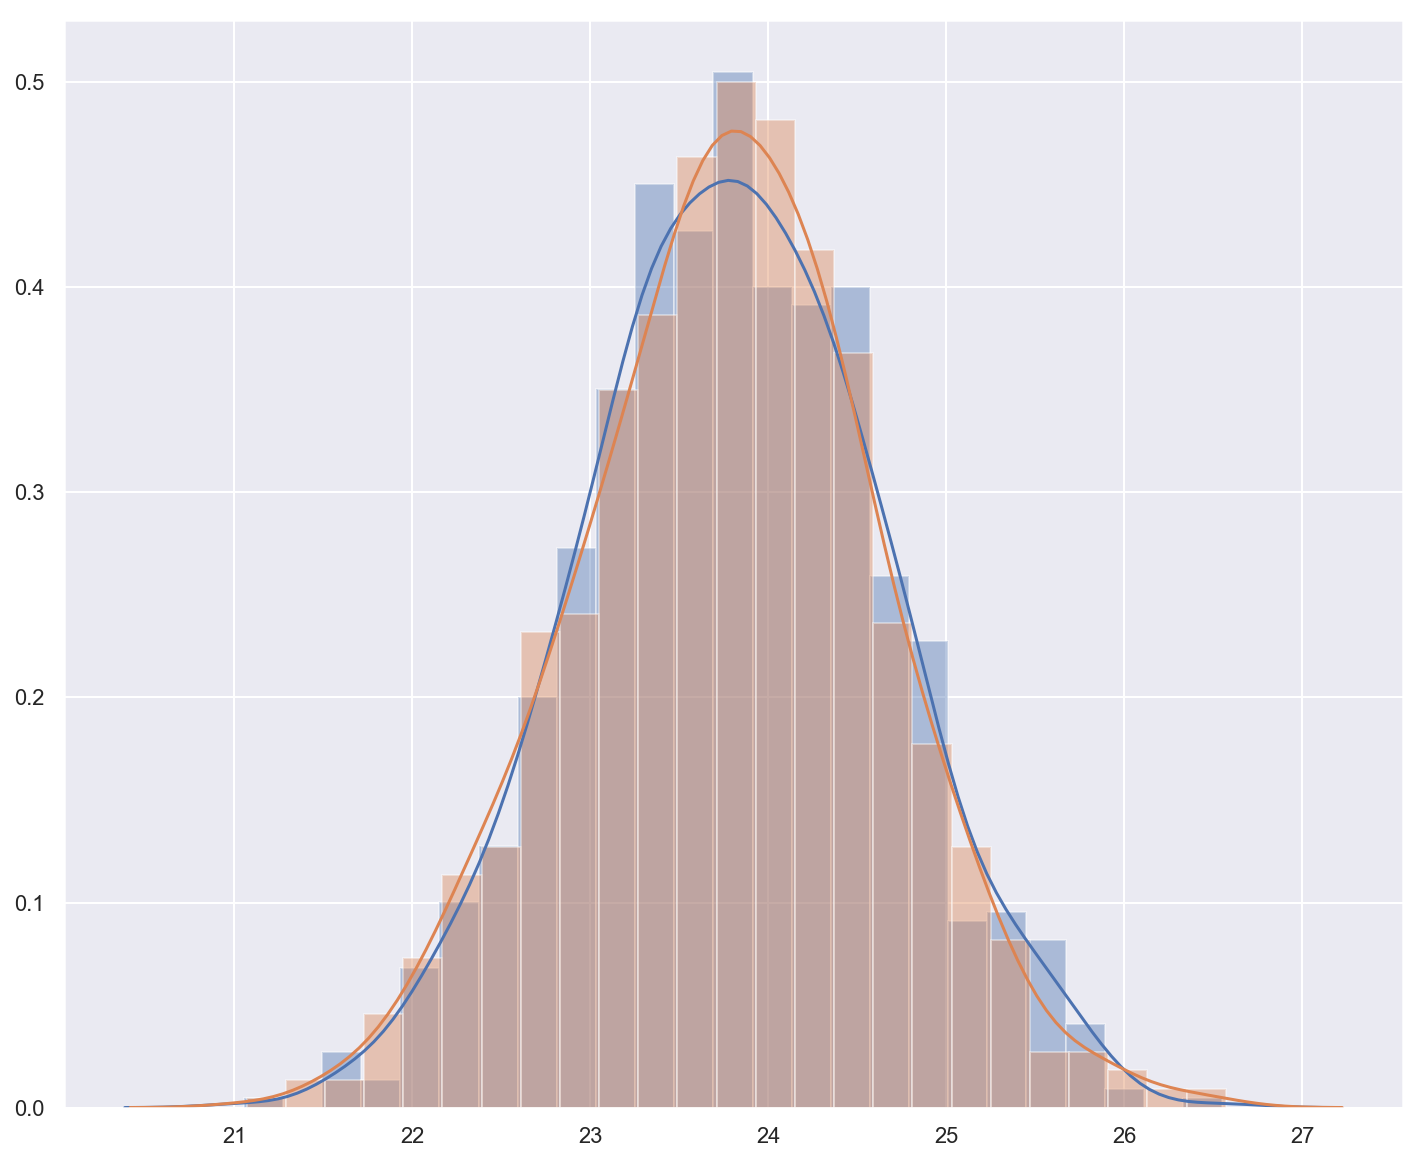

In [33]:
# Plot sample Distribution
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control_sample) # Blue distribution
sns.distplot(exp_sample) # Orange distribution

In [34]:
# Test whether variances are equal
np.var(control) == np.var(experimental)

False

In [35]:
# Calculate the p_value
stats.ttest_ind(control, experimental, equal_var=False)

Ttest_indResult(statistic=0.0, pvalue=1.0)

### Perform ANOVA test

In [36]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'Quantity ~ C(Region)'
lm = ols(formula, df3).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq       df             F  PR(>F)
C(Region)  1.990484e-21      5.0  1.100611e-24     1.0
Residual   2.260259e+07  62489.0           NaN     NaN


The result **p (1.0) > α**, so we reject the null hypothesis. The amount of Chai sold is different between the supplier sources of North America vs other regions.

## Question 4: Do customers in North America purchase the same quantity as other regions?

    Ho: The mean quantity of products ordered by customers in North America is the same as other regions.

    Ha: The mean quantity of products ordered by customers in North America is different regionally.

In [37]:
# Extract Order Detail data as a pandas dataframe using a SQL query
df4 = pd.read_sql_query('''
 SELECT c.Region, od.OrderId, od.Quantity, o.OrderDate
 FROM "Order" o
 JOIN Customer c ON c.Id = o.CustomerId
 JOIN OrderDetail od ON od.OrderId = o.Id
 ''', engine)

2019-05-20 14:47:10,023 INFO sqlalchemy.engine.base.Engine 
 SELECT c.Region, od.OrderId, od.Quantity, o.OrderDate
 FROM "Order" o
 JOIN Customer c ON c.Id = o.CustomerId
 JOIN OrderDetail od ON od.OrderId = o.Id
 
2019-05-20 14:47:10,023 INFO sqlalchemy.engine.base.Engine ()


In [38]:
# Show dataframe
df4.head()

,Region,OrderId,Quantity,OrderDate
0,Western Europe,10248,12,2012-07-04
1,Western Europe,10248,10,2012-07-04
2,Western Europe,10248,5,2012-07-04
3,Western Europe,10249,9,2012-07-05
4,Western Europe,10249,40,2012-07-05


In [39]:
#Convert OrderDate from ojbject to int
df4['OrderDate'] = df4['OrderDate'].astype('datetime64[ns]')

#Pull out month and year from OrderDate
df4['Month'] = df4['OrderDate'].dt.month
df4['Year'] = df4['OrderDate'].dt.year

# Filter orders from 2012 and 2014 and leave only 2013
df4.drop(df4[ (df4['Year'] == 2012) | (df4['Year'] == 2014) ].index, inplace=True)

In [40]:
#Show dataframe
df4.head()

,Region,OrderId,Quantity,OrderDate,Month,Year
398,British Isles,10400,21,2013-01-01,1,2013
399,British Isles,10400,35,2013-01-01,1,2013
400,British Isles,10400,30,2013-01-01,1,2013
401,North America,10401,18,2013-01-01,1,2013
402,North America,10401,70,2013-01-01,1,2013


In [41]:
# Group data by region and show mean
df4.groupby('Region').Quantity.mean()

Region
British Isles      20.495050
Central America    12.800000
Eastern Europe      9.833333
North America      27.643192
Northern Europe    23.175676
Scandinavia        16.447368
South America      21.605634
Southern Europe    15.894737
Western Europe     27.619835
Name: Quantity, dtype: float64

In [42]:
df4 = df4.groupby(['Region', 'Month'])['Quantity'].mean().reset_index()

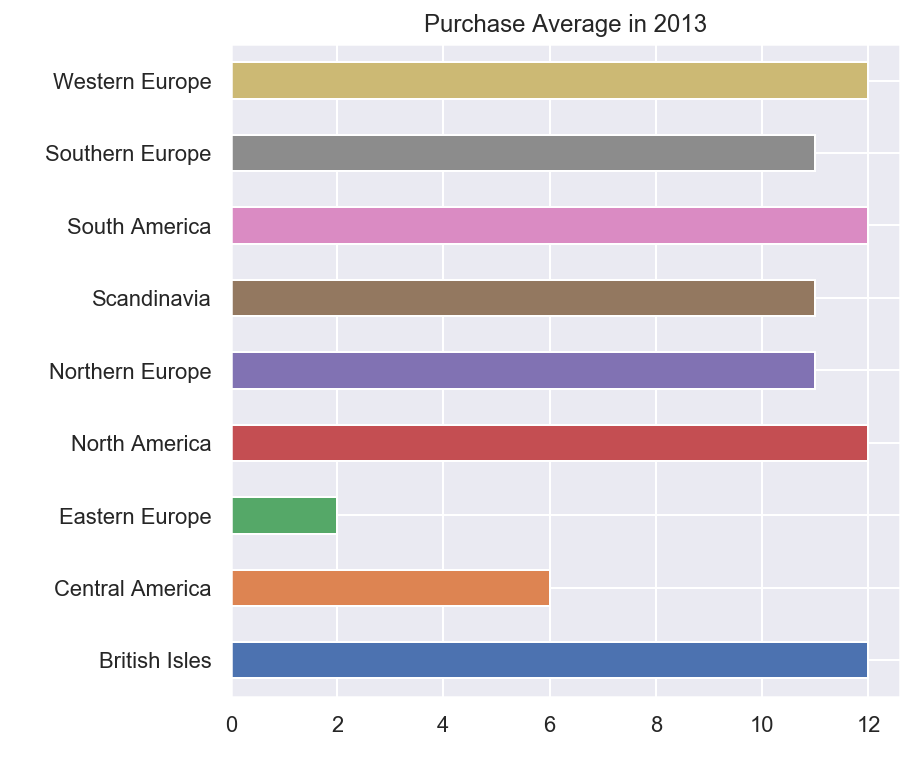

In [43]:
# Plot the number of orders, total revenue per order and average revenue per order for each region
fig, (ax1) = plt.subplots(1, 1, figsize=(6,6))
df4.groupby(['Region'])['Month'].count().plot(kind='barh', ax=ax1)
ax1.set_title('Purchase Average in 2013')
ax1.set_ylabel(' ')
ax1.set_xlabel(' ')
fig.subplots_adjust(hspace=0.1);

In [44]:
# Create control group: Price per order in North America
control = df4[df4['Region'] == 'North America']
control = control['Quantity']

# Create experimental group: Price per order everywhere else
experimental = df4[df4['Region'] != 'North America']
experimental = experimental['Quantity']

In [45]:
# Calculate the difference between distribution means
control.mean()
experimental.mean()
experimental.mean() - control.mean()

-5.648061842206118

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


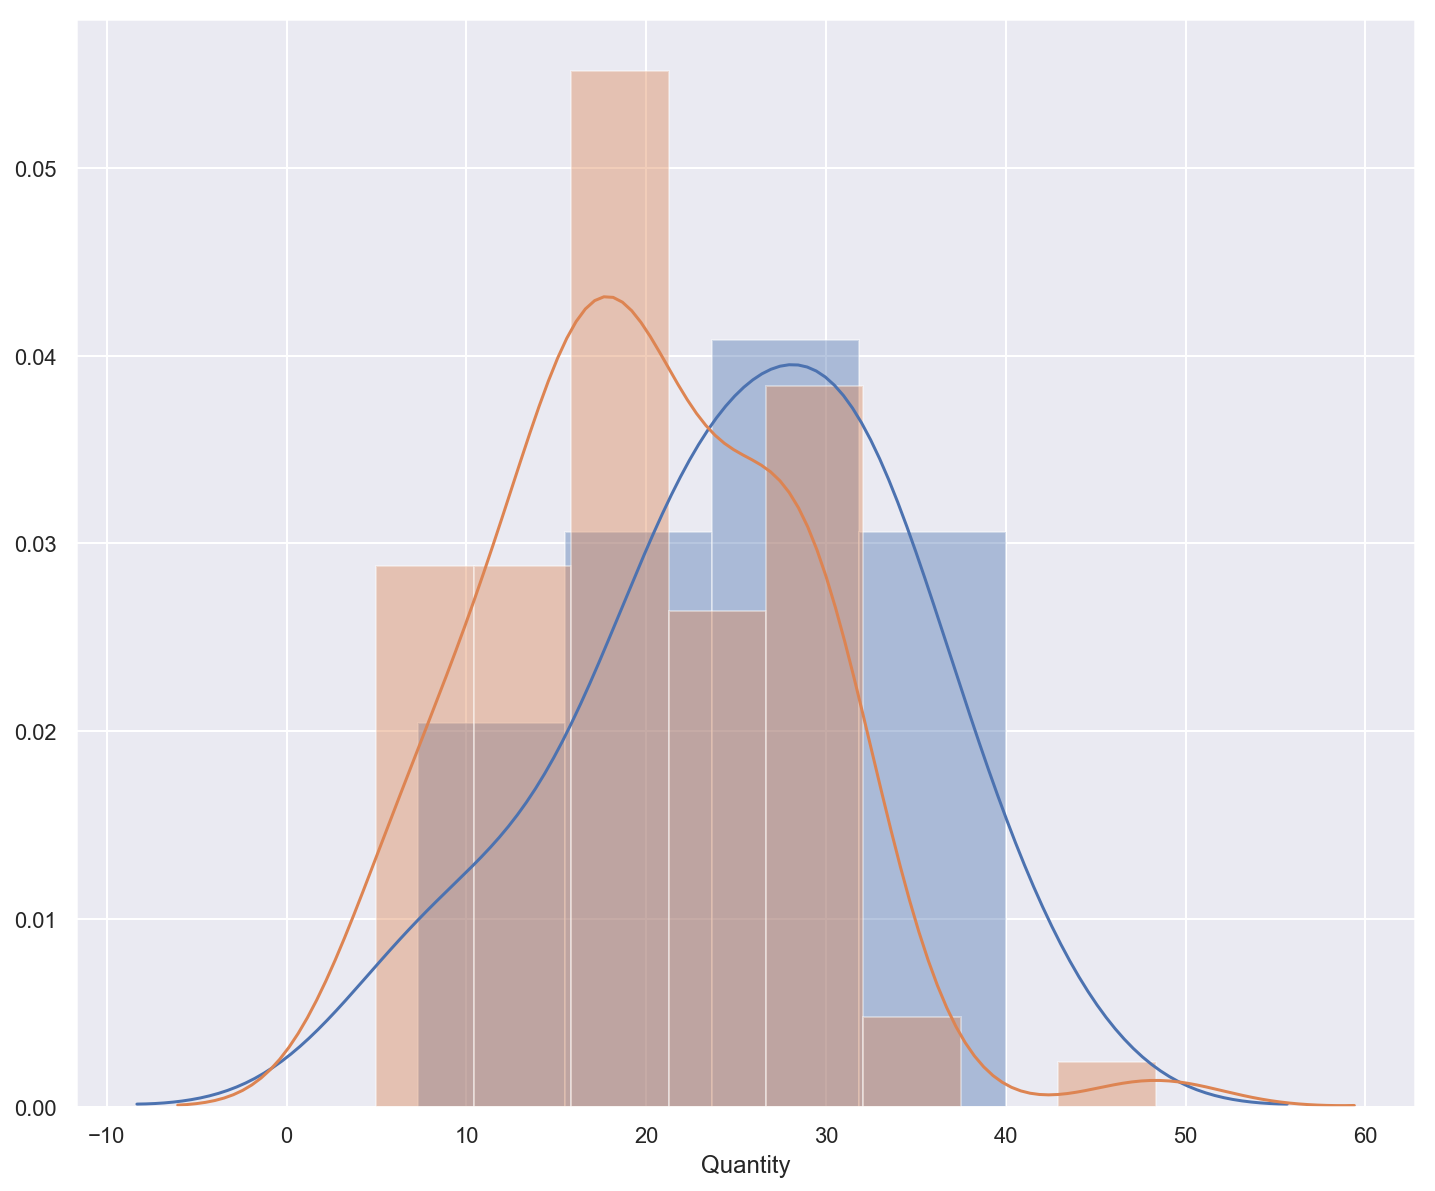

In [46]:
# Plot data and run normality test
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control) # Blue distribution
sns.distplot(experimental) # Orange distribution

In [47]:
# Create function to sample with replacement
def get_sample(df4, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df4)
        sample.append(x)
    return sample

# Create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# Combine functions to create a sample distribution
# Create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df4, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df4, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    return sample_dist

# Create sample distributions of sample mean for control and target
control_sample = create_sample_distribution(control)
exp_sample = create_sample_distribution(experimental)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


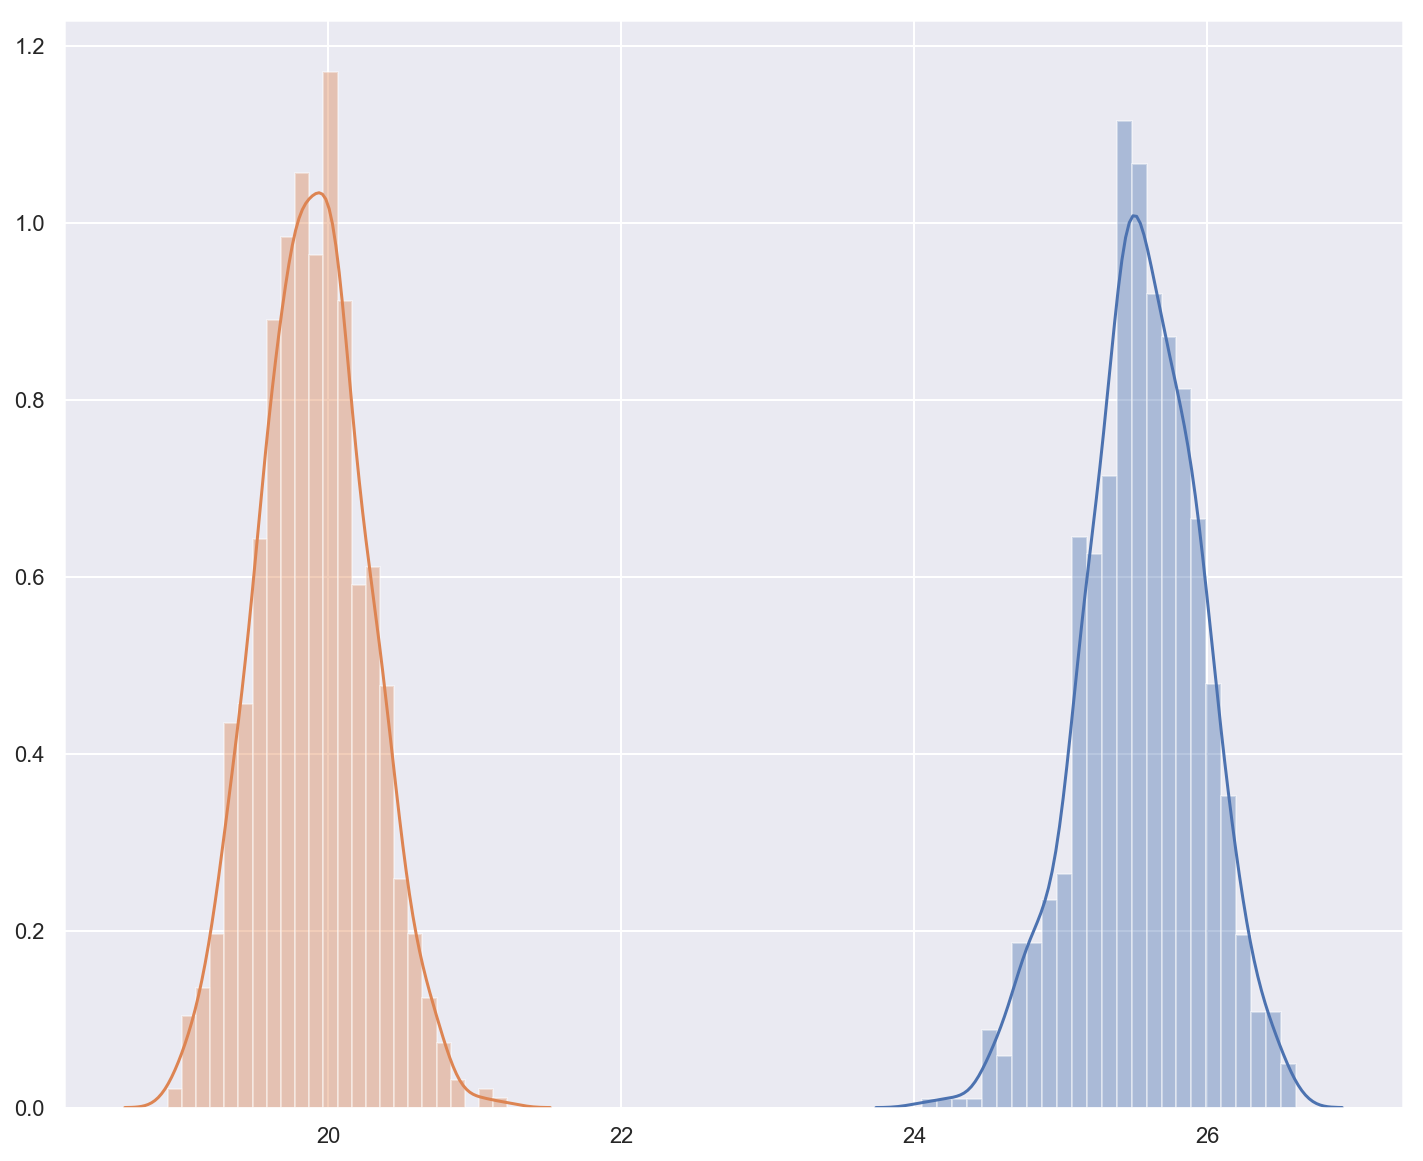

In [48]:
# Plot sample Distribution
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control_sample) # Blue distribution
sns.distplot(exp_sample) # Orange distribution

In [49]:
# Test whether variances are equal
np.var(control) == np.var(experimental)

False

### Perform a one-way ANOVA test

In [50]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'Quantity ~ C(Region)'
lm = ols(formula, df4).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq    df         F    PR(>F)
C(Region)  2543.352758   8.0  6.465086  0.000002
Residual   3933.981035  80.0       NaN       NaN


The result **p (.000002) < α**, so we reject the null hypothesis.